# Appendix

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as prfs
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from itertools import compress, combinations
%matplotlib inline 

In [2]:
df = pd.read_csv("hour.csv")
df = df[['season', 'yr', 'mnth', 'hr', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed', 'cnt']]

##  Plot of cnt by hour for the average working day

In [3]:
def houravgs(df):
    return df.groupby('hr',as_index=False)['cnt'].mean()

In [4]:
def barplothouravg(df, legendnames = [], titlenotes = ''):
    figure(figsize=(12,7))
    if df.shape[1] == 3:
        plt.bar(df.iloc[:,0]-0.125,df.iloc[:,1],width=0.25)
        plt.bar(df.iloc[:,0]+0.125,df.iloc[:,2],width=0.25)
        plt.legend(legendnames,loc='upper left')
    else:
        plt.bar(df.iloc[:,0], df.iloc[:,1])
    plt.xticks(np.arange(0,24))
    plt.xlabel('Hour')
    plt.ylabel('Count of Bike Rentals')
    plt.title('Bike Rental Volume by Hour '+ titlenotes)
    return

In [5]:
df_workday = df[df.workingday==1]
workdayhravg = houravgs(df_workday)

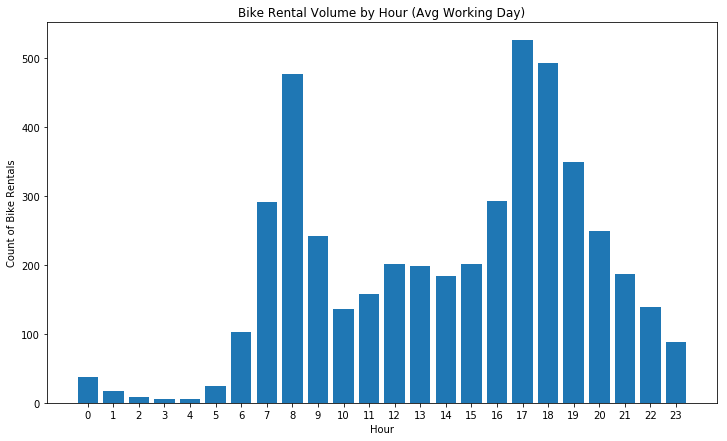

In [6]:
barplothouravg(workdayhravg, titlenotes='(Avg Working Day)')

In [7]:
def hourlyvalues(df):
    hvlist = []
    for i in range(24):
        hrvals = df[df.hr==i].cnt
        hvlist.append(hrvals)
    return hvlist

In [8]:
workdayhrvals = hourlyvalues(df_workday)

In [9]:
def boxplothour(hrlist, titlenotes = ''):
    figure(figsize=(12,7))
    plt.boxplot(hrlist)
    plt.xticks(np.arange(1,25),np.arange(0,24))
    plt.xlabel('Hour')
    plt.ylabel('Count of Bike Rentals')
    plt.title('Bike Rental Volume by Hour '+ titlenotes)
    return

C:\Users\Charlie\Anaconda2\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


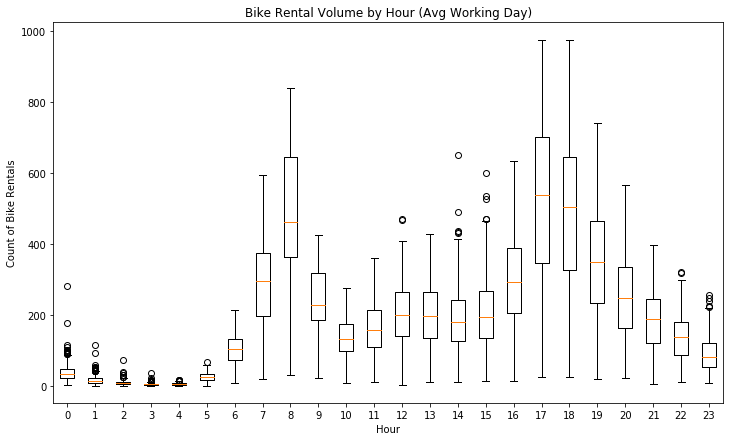

In [10]:
boxplothour(workdayhrvals,'(Avg Working Day)')

In [11]:
def meansRemoveOutliers(hrvals):
    fhrlist = []
    for i in range(24):
        q1 = hrvals[i].quantile(.25)
        q3 = hrvals[i].quantile(.75)
        iqr = q3 - q1
        fhrlist.append(hrvals[i][hrvals[i].between(q1-1.5*iqr,q3+1.5*iqr)])
    indices = np.array([])
    hmeans = np.array([])
    for i in range(len(fhrlist)):
        indices = np.append(indices,i)
        hmeans = np.append(hmeans,fhrlist[i].mean())
    df_hmeans = pd.DataFrame(data=hmeans, index = indices, columns = ['cnt'])
    return df_hmeans

In [12]:
fworkdayhravg = meansRemoveOutliers(workdayhrvals)

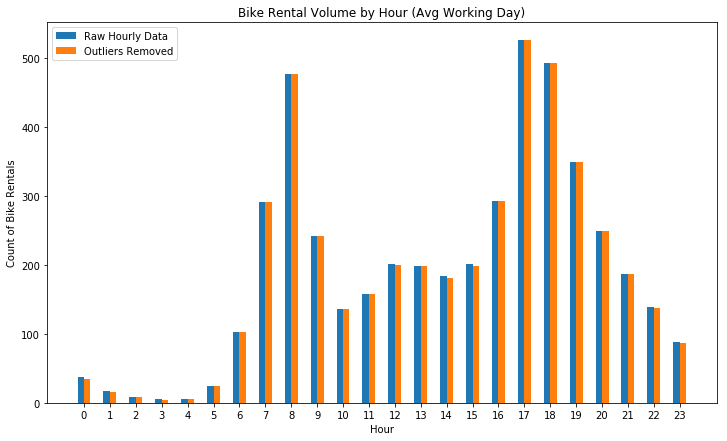

In [13]:
df_load = pd.concat([workdayhravg,fworkdayhravg],axis=1)
barplothouravg(df_load,['Raw Hourly Data','Outliers Removed'],'(Avg Working Day)')

## Plot of cnt by hour for the average non-working day

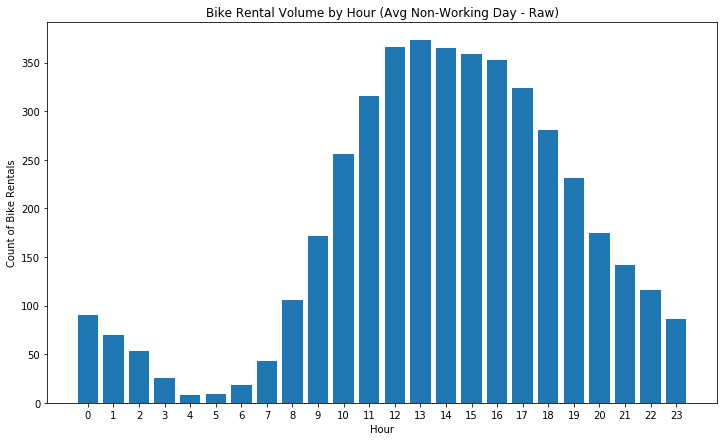

In [14]:
df_nonworkday = df[df.workingday==0]
nworkdayhravg = houravgs(df_nonworkday)
barplothouravg(nworkdayhravg,titlenotes='(Avg Non-Working Day - Raw)')

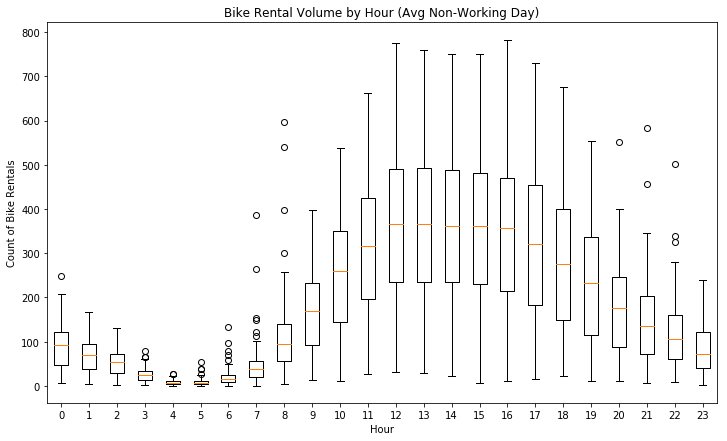

In [15]:
nworkdayhrvals = hourlyvalues(df_nonworkday)
boxplothour(nworkdayhrvals,'(Avg Non-Working Day)')

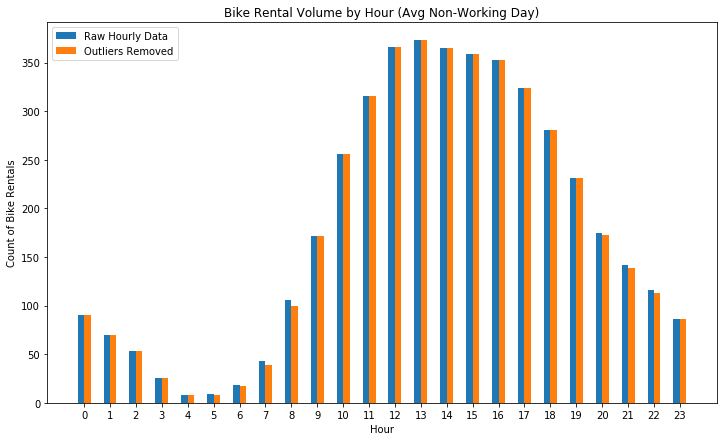

In [16]:
fnworkdayhravg = meansRemoveOutliers(nworkdayhrvals)
df_load = pd.concat([nworkdayhravg,fnworkdayhravg],axis=1)
barplothouravg(df_load,['Raw Hourly Data','Outliers Removed'],'(Avg Non-Working Day)')

## Plot of cnt by hour for the average rainy day

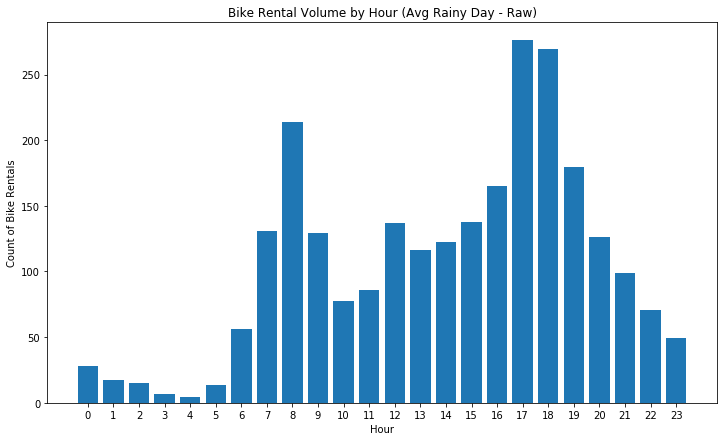

In [17]:
df_rainyday = df[df.weathersit>=3]
rainydayhravg = houravgs(df_rainyday)
barplothouravg(rainydayhravg,titlenotes='(Avg Rainy Day - Raw)')

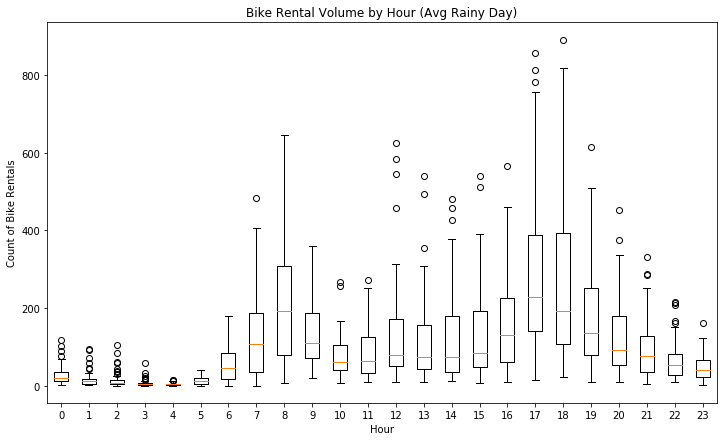

In [18]:
rainydayhrvals = hourlyvalues(df_rainyday)
boxplothour(rainydayhrvals,'(Avg Rainy Day)')

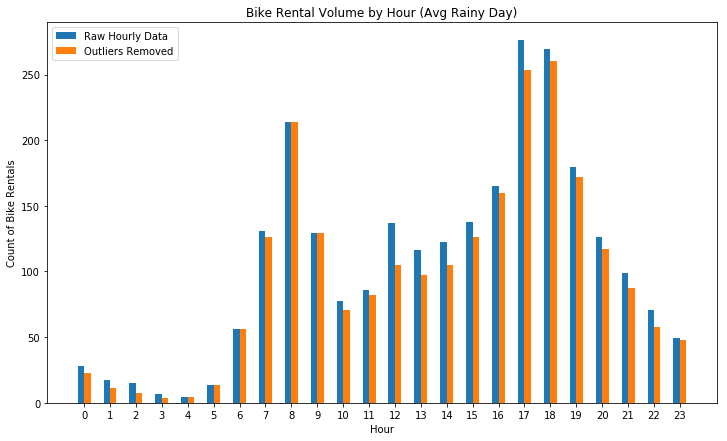

In [19]:
frainydayhravg = meansRemoveOutliers(rainydayhrvals)
df_load = pd.concat([rainydayhravg,frainydayhravg],axis=1)
barplothouravg(df_load,['Raw Hourly Data','Outliers Removed'],'(Avg Rainy Day)')

## Plot of cnt by hour for the average non-rainy day

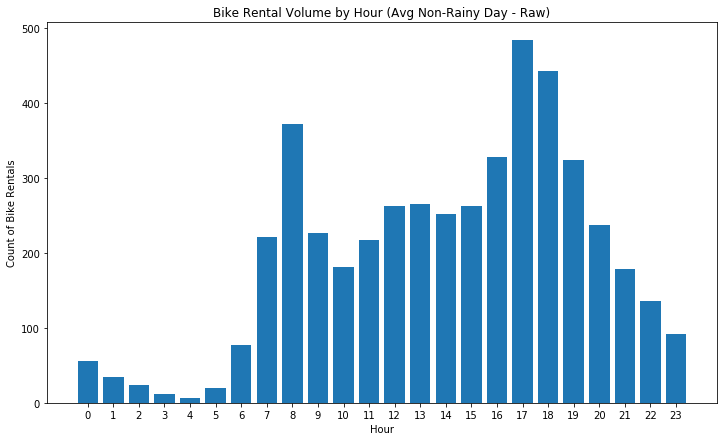

In [20]:
df_nonrainyday = df[df.weathersit<=2]
nrainydayhravg = houravgs(df_nonrainyday)
barplothouravg(nrainydayhravg,titlenotes='(Avg Non-Rainy Day - Raw)')

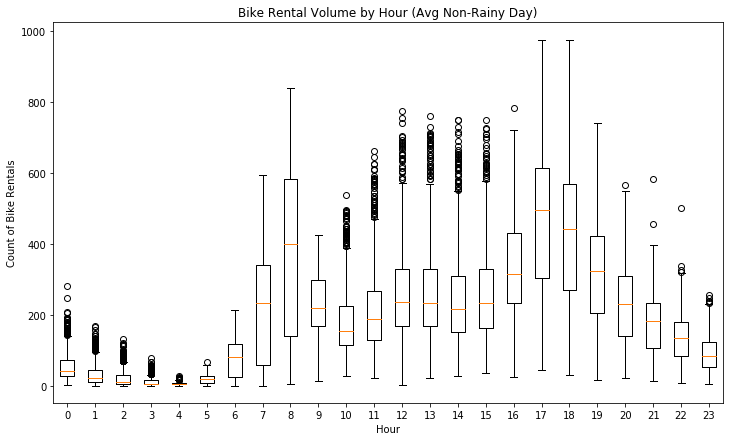

In [21]:
nrainydayhrvals = hourlyvalues(df_nonrainyday)
boxplothour(nrainydayhrvals,'(Avg Non-Rainy Day)')

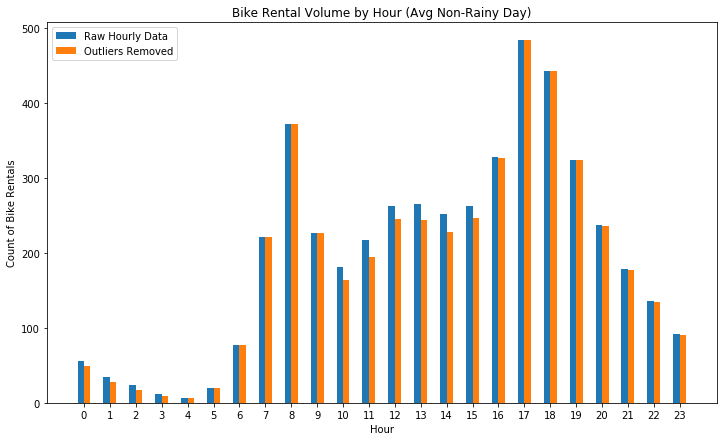

In [22]:
fnrainydayhravg = meansRemoveOutliers(nrainydayhrvals)
df_load = pd.concat([nrainydayhravg,fnrainydayhravg],axis=1)
barplothouravg(df_load,['Raw Hourly Data','Outliers Removed'],'(Avg Non-Rainy Day)')

## Outlier removal methods tested

In [23]:
def removeOutliers(df,featurelist,thresh=1.5):
    df2 = df.copy()
    feat1 = featurelist[0]
    feat2 = featurelist[1]
    
    for i in df[feat1].unique():
        for j in df[feat2].unique():
            vals = df[(df[feat1] == i) & (df[feat2] == j)].cnt
            q1 = vals.quantile(.25)
            q3 = vals.quantile(.75)
            iqr = q3-q1
            dropindices = df.index[((df[feat1] == i) & (df[feat2]==j) & (df.cnt > q3+thresh*iqr)) 
                                       | ((df[feat1] == i) & (df[feat2] ==j) & (df.cnt < q1-thresh*iqr))]
            df2 = df2.drop(dropindices)
    
    return df2

In [24]:
def predictCnt(df, algo, impute=True, scale=True):
    df_train, df_test = df.iloc[:len(df)/2], df.iloc[len(df)/2:]
    X_train, y_train = df_train[df_train.columns.drop('cnt')], df_train.cnt
    X_test, y_test = df_test[df_test.columns.drop('cnt')], df_test.cnt
    
    pipechoices = [('myImputer',Imputer()),('myScaler',StandardScaler()),('masterAlg',algo)]
    filt = [impute,scale,True]
    pipecontent = list(compress(pipechoices,filt))
    
    mypipeline = Pipeline(pipecontent)
    mypipeline.fit(X_train,y_train)
    y_pred = mypipeline.predict(X_test)
    results = [y_test,y_pred]
    return results

In [25]:
def RMSE(y_test,y_pred):
    return (((y_test - y_pred)**2).sum()/len(y_test))**0.5

In [26]:
df2 = df.copy()
df2 = df2.sample(frac=1)

### Testing and Tuning Sklearn Outlier Detection Method

In [27]:
from sklearn.neighbors import LocalOutlierFactor

In [28]:
testdf = pd.DataFrame(columns = ['# neighbors','RMSE'])

In [29]:
for i in range(1,45,2):
    toutlierclf = LocalOutlierFactor(n_neighbors=i)
    toutlier_pred = toutlierclf.fit_predict(df2)
    df2_filtt = df2.copy()
    toutliers = np.argwhere(toutlier_pred == -1)
    df2_filtt = df2_filtt.drop([int(x) for x in toutliers.astype(list)])
    tfiltresults = predictCnt(df2_filtt,LinearRegression(),impute=True,scale=True)
    trmse = RMSE(tfiltresults[0],tfiltresults[1])
    temp = pd.DataFrame(data =[[i,trmse]], columns=['# neighbors','RMSE'])
    testdf = testdf.append(temp,ignore_index=True)

In [30]:
testdf.sort_values(by='RMSE').head(3)

,# neighbors,RMSE
4,9,140.860496
5,11,141.255542
6,13,141.299622


In [31]:
outlierclf = LocalOutlierFactor(n_neighbors=31)
outlier_pred = outlierclf.fit_predict(df2)
print 'Predicted',np.bincount(outlier_pred+1)[0],'outliers,',np.bincount(outlier_pred+1)[2],'points remain'

Predicted 1738 outliers, 15641 points remain


In [32]:
print np.round(float(15641)*100/len(df2),decimals=2),"percent of original data with outliers removed"

90.0 percent of original data with outliers removed


In [33]:
df2_filt = df2.copy()
outliers = np.argwhere(outlier_pred == -1)
df2_filt = df2_filt.drop([int(x) for x in outliers.astype(list)])

In [34]:
sklrnresults = predictCnt(df2_filt,LinearRegression(),impute=True,scale=True)
print 'The RMSE for the model predicted by Linear Regression is: ',RMSE(sklrnresults[0],sklrnresults[1])

The RMSE for the model predicted by Linear Regression is:  141.834408789


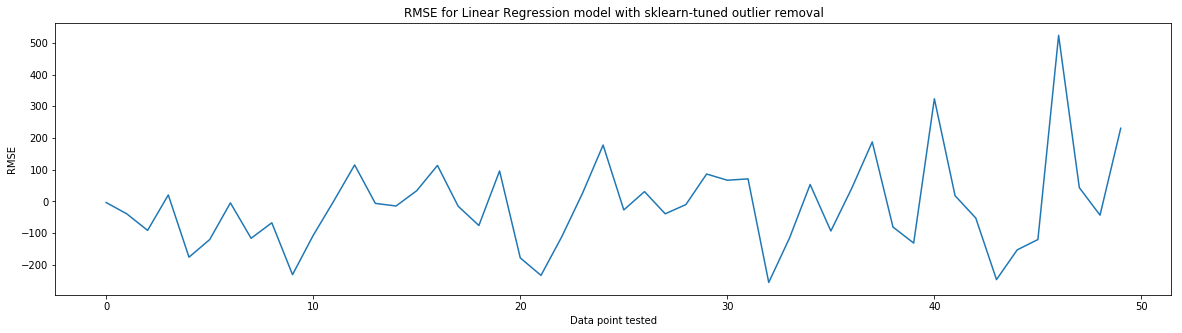

In [35]:
output1 = sklrnresults[0]-sklrnresults[1]
output1 = output1.iloc[:50]

figure(figsize=(20,5))
plt.plot(np.arange(len(output1)),output1)
plt.xlabel('Data point tested')
plt.ylabel('RMSE')
plt.title('RMSE for Linear Regression model with sklearn-tuned outlier removal')
plt.show()

##### Manually iterating through combinations of features to test outlier removal

In [ ]:
featlist = ['season','mnth','hr','workingday','weathersit','null']
combolist = list(combinations(featlist,2))

In [ ]:
df2['null'] = 1
cntpredictions = pd.DataFrame(columns = ['feat1','feat2','thresh','RMSE','len(df)'])
for j in [x*.1 for x in range(0,25)]:
    for i in range(len(combolist)):
        df2_filt = removeOutliers(df2,combolist[i],j)
        results = predictCnt(df2_filt,LinearRegression())
        rmse = RMSE(results[0],results[1])
        temp = pd.DataFrame(data = [[combolist[i][0],combolist[i][1],j,rmse,len(df2_filt)]],
                            columns=['feat1','feat2','thresh','RMSE','len(df)'])
        cntpredictions = cntpredictions.append(temp,ignore_index=True)
df2 = df2[df2.columns.drop('null')]

In [ ]:
cntpredictions[cntpredictions['thresh'] >= 0.8].sort_values(by='RMSE', ascending = True).head(3)

In [ ]:
df2_filt = df2.copy()
for i in df.workingday.unique():
    vals = df2_filt[df2_filt.workingday == i].cnt
    q1 = vals.quantile(.25)
    q3 = vals.quantile(.75)
    iqr = q3-q1
    dropindices = df2_filt.index[((df2_filt.workingday == i) & (df2_filt.cnt > q3+.8*iqr)) 
                                 | ((df2_filt.workingday == i) & (df2_filt.cnt < q1-.8*iqr))]
    df2_filt = df2_filt.drop(dropindices)

In [ ]:
print np.round(float(len(df2_filt))*100/len(df2),decimals=2),"percent of original data with outliers removed"

In [ ]:
manualresults = predictCnt(df2_filt,LinearRegression())
rmse = RMSE(manualresults[0],manualresults[1])
print 'The RMSE for this model is',rmse

In [ ]:
output2 = manualresults[0] - manualresults[1]
output2 = output2.iloc[:50]

figure(figsize=(20,5))
plt.plot(np.arange(len(output2)),output2)
plt.xlabel('Data point tested')
plt.ylabel('RMSE')
plt.title('RMSE for Linear Regression model with manually-tuned outlier removal')
plt.show()

### Building a pipeline that includes an imputer and standard scaler

In [ ]:
df2_train, df2_test = df2.iloc[:len(df2)/2], df2.iloc[len(df2)/2:]
X_train, y_train = df2_train[df2_train.columns.drop('cnt')], df2_train.cnt
X_test, y_test = df2_test[df2_test.columns.drop('cnt')], df2_test.cnt

mypipeline = Pipeline([
    ('myImputer',Imputer()),
    ('myScaler',StandardScaler()),
    ('masterAlg',LinearRegression())
])

### Predicting the CNT using linear regression

In [ ]:
mypipeline.fit(X_train,y_train)
y_pred = mypipeline.predict(X_test)

In [ ]:
print 'The RMSE for the model predicted by Linear Regression is: ',RMSE(y_test,y_pred)

In [ ]:
output3 = y_test-y_pred
output3 = output3.iloc[:50]

figure(figsize=(20,5))
plt.plot(np.arange(len(output3)),output3)
plt.xlabel('Data point tested')
plt.ylabel('RMSE')
plt.title('RMSE for Linear Regression model without outlier removal')
plt.show()

### Generating a visual comparison of the manual method with the original df

In [ ]:
figure(figsize=(20,10))
plt.plot(np.arange(len(output2)),output3)
plt.plot(np.arange(len(output2)),output2)
plt.plot(np.arange(len(output2)),output1)
plt.xlabel('Data point tested')
plt.ylabel('RMSE')
plt.legend(['Sklearn LocalOutlierFactor()','Manual Outlier Removal','No Outliers Removed'])
plt.title('Sample of RMSE for Linear Regression model without various outlier removal methods')
plt.show()

### Using manual outlier removal, comparing Linear Regression to Random Forest Regressor

#### Random Forest:

In [ ]:
forestmanualresults = predictCnt(df2_filt,RandomForestRegressor(n_estimators=50,min_samples_split=2,random_state=0))
rmse = RMSE(forestmanualresults[0],forestmanualresults[1])
print 'The RMSE for this model is',rmse

In [ ]:
output4 = forestmanualresults[0] - forestmanualresults[1]
output4 = output4.iloc[:50]

figure(figsize=(20,5))
plt.plot(np.arange(len(output4)),output4)
plt.xlabel('Data point tested')
plt.ylabel('RMSE')
plt.title('RMSE for Random Forest Regression model with manually-tuned outlier removal')
plt.show()

#### Linear Regression:

In [ ]:
figure(figsize=(20,10))
plt.plot(np.arange(len(output2)),output4)
plt.plot(np.arange(len(output2)),output2)
plt.xlabel('Data point tested')
plt.ylabel('RMSE')
plt.legend(['Random Forest Regression','Linear Regression'])
plt.title('Sample of RMSE for Linear Regression vs Random Forest Regression with manual outlier removal methods')
plt.show()

## Identifying the parameters which influence the prediction the most

In [ ]:
modelcoefs = abs(mypipeline.get_params('masterAlg')['masterAlg'].coef_)

In [ ]:
loader = np.array([(X_train.columns),(modelcoefs)]).T
coef_rank = pd.DataFrame(data = loader, columns = ['Feature','abs(Model Coef)'])

In [ ]:
coef_rank.sort_values(by = 'abs(Model Coef)', ascending=False)

## Predicting whether it is a raining day (weathersit) or not from the non-weather columns 

In [ ]:
def binaryPerformance(results):
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(results[:,0], results[:,1]).ravel()
    tpr = float(tp)/(tp + fn)
    tnr = float(tn)/(tn + fp)
    ppr = float(tp)/(tp + fp)
    npr = float(tn)/(tn + fn)
    accuracy = float(tp+tn)/(tp+tn+fp+fn)
    f1 = 2.0/(1.0/tpr + 1.0/ppr)
    columns = ['True Positives Rate','True Negatives Rate','Positive Predicted Rate',
               'Negative Predicted Rate','F1 Score','Accuracy']
    perfmetrics = pd.DataFrame(data=[[tpr,tnr,ppr,npr,f1,accuracy]],columns=columns)
    return perfmetrics

In [ ]:
def predictWeather(df, algo, impute=True, scale=True):
    df_train, df_test = df.iloc[:len(df)/2], df.iloc[len(df)/2:]
    X_train, y_train = df_train[df_train.columns.drop(['weathersit','atemp','hum','windspeed'])], df_train.weathersit
    X_test, y_test = df_test[df_test.columns.drop(['weathersit','atemp','hum','windspeed'])], df_test.weathersit
    
    pipechoices = [('myImputer',Imputer()),('myScaler',StandardScaler()),('masterAlg',algo)]
    filt = [impute,scale,True]
    pipecontent = list(compress(pipechoices,filt))
    
    mypipeline = Pipeline(pipecontent)
    mypipeline.fit(X_train,y_train)
    y_pred = mypipeline.predict(X_test)
    results = np.array([y_test,y_pred])
    return np.transpose(results)

In [ ]:
df3 = df2.copy()
df3.weathersit = df3.weathersit >= 3

##### Logistic Regression

In [ ]:
weathercf = predictWeather(df3,LogisticRegression(class_weight='balanced'))
performance = binaryPerformance(weathercf)
performance

##### SVM

In [ ]:
weathercf2 = predictWeather(df3,SVC(kernel='sigmoid'))
performance2 = binaryPerformance(weathercf2)
performance2

##### KNN

In [ ]:
knnweathertable = pd.DataFrame(columns = ['# Neighbors','Scaled','F1 Score','Accuracy'])
for i in range(1,50,2):
    for j in range(0,2):
        resultlist = predictWeather(df3,KNeighborsClassifier(n_neighbors=i),scale=j)
        performance = binaryPerformance(resultlist)
        loader = pd.DataFrame(data=[[i,j,performance['F1 Score'][0],performance['Accuracy'][0]]],columns=['# Neighbors','Scaled','F1 Score','Accuracy'])
        knnweathertable = knnweathertable.append(loader)

In [ ]:
knnweathertable.sort_values(by='Accuracy',ascending=False).head(3)

In [ ]:
weathercf3 = predictWeather(df3,KNeighborsClassifier(n_neighbors=5),scale=1)
performance3 = binaryPerformance(weathercf3)
performance3

##### Random Forest

In [ ]:
weathercf4 = predictWeather(df3,RandomForestClassifier(n_estimators=275,min_samples_split=7,random_state=0,class_weight='balanced_subsample'),scale=1)
performance4 = binaryPerformance(weathercf4)
performance4

## Predicting whether it is a working day or not from the other columns 

In [ ]:
def predictWorkingDay(df, algo, impute=True, scale=True):
    #setting up the frames for training and testing
    df_train, df_test = df.iloc[:len(df)/2], df.iloc[len(df)/2:]
    X_train, y_train = df_train[df_train.columns.drop('workingday')], df_train.workingday
    X_test, y_test = df_test[df_test.columns.drop('workingday')], df_test.workingday
    
    pipechoices = [('myImputer',Imputer()),('myScaler',StandardScaler()),('masterAlg',algo)]
    filt = [impute,scale,True]
    pipecontent = list(compress(pipechoices,filt))
    
    mypipeline = Pipeline(pipecontent)
    mypipeline.fit(X_train,y_train)
    y_pred = mypipeline.predict(X_test)
    results = np.array([y_test,y_pred])
    return np.transpose(results)

##### Logistic Regression

In [ ]:
workcf = predictWorkingDay(df2,LogisticRegression(class_weight='balanced'),impute=False,scale=False)
workperf = binaryPerformance(workcf)
workperf

##### SVM

In [ ]:
workcf2 = predictWorkingDay(df2,SVC(kernel='rbf',class_weight='balanced'))
workperf2 = binaryPerformance(workcf2)
workperf2

##### KNN

In [ ]:
knnworktable = pd.DataFrame(columns = ['# Neighbors','Scaled','F1 Score','Accuracy'])
for i in range(3,30,2):
    for j in range(0,2):
        resultlist = predictWorkingDay(df2,KNeighborsClassifier(n_neighbors=i,weights='distance'),scale=j)
        performance = binaryPerformance(resultlist)
        loader = pd.DataFrame(data=[[i,j,performance['F1 Score'][0],performance['Accuracy'][0]]],columns=['# Neighbors','Scaled','F1 Score','Accuracy'])
        knnworktable = knnworktable.append(loader)

In [ ]:
knnworktable.sort_values(by='Accuracy',ascending=False).head(3)

In [ ]:
workcf3 = predictWorkingDay(df2,KNeighborsClassifier())
workperf3 = binaryPerformance(workcf3)
workperf3

##### Random Forest

In [ ]:
workcf4 = predictWorkingDay(df2,RandomForestClassifier(n_estimators=250,min_samples_split=5,random_state=0,class_weight='balanced_subsample'),scale=1)
workperf4 = binaryPerformance(workcf4)
workperf4

In [ ]:
df_train, df_test = df.iloc[:len(df)/2], df.iloc[len(df)/2:]
X_train, y_train = df_train[df_train.columns.drop('workingday')], df_train.workingday
X_test, y_test = df_test[df_test.columns.drop('workingday')], df_test.workingday
forest = RandomForestClassifier(n_estimators=250,min_samples_split=5,random_state=0,class_weight='balanced_subsample')
forest.fit(X_train,y_train)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
X_train = df3[df3.columns.drop(['weathersit','atemp','hum','windspeed'])]
X_test = df3.weathersit

mypipeline = Pipeline([
    ('myImputer',Imputer()),
    ('myScaler',StandardScaler()),
    ('masterAlg',KMeans(n_clusters=2))
])
mypipeline.fit(X_train)

X_pred = mypipeline.get_params('masterAlg')['masterAlg'].labels_
results = np.array([X_test, X_pred]).T

In [ ]:
binaryPerformance(results)